In [0]:
#IDS 561 - Project
#Black Friday Sales Prediction using PySpark
#Gnana Teja Peddi
#Shubham Sharma

In [0]:
#Setting Environment Variables
import os
import sys

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
#Installing JDK
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
#Getting Spark Installer
!wget -q http://apache.mirrors.pair.com/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
!ls

sample_data  spark-2.4.4-bin-hadoop2.7.tgz  train.csv


In [0]:
#Untarring the Spark Installer 
!tar -xvf spark-2.4.4-bin-hadoop2.7.tgz

spark-2.4.4-bin-hadoop2.7/
spark-2.4.4-bin-hadoop2.7/R/
spark-2.4.4-bin-hadoop2.7/R/lib/
spark-2.4.4-bin-hadoop2.7/R/lib/sparkr.zip
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/R.css
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/00Index.html
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/aliases.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/AnIndex
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdx
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdb
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/paths.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/te

In [0]:
#Installing findspark
!pip install -q findspark

In [0]:
#Creating local Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [0]:
import re;
from pyspark import SparkConf, SparkContext, HiveContext;
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from heapq import nlargest;

In [0]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import pyspark.sql.functions as fn

In [0]:
sc = SparkContext.getOrCreate();

In [0]:
sqlContext = HiveContext(sc);

# **Loading the Dataset**

In [0]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('train.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)



In [0]:
#Converting spark dataframe to pandas dataframe
pd_df = df.toPandas()

# **Exploratory Data Analysis**

In [0]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int32
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int32
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int32
Product_Category_1            550068 non-null int32
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int32
dtypes: float64(2), int32(5), object(5)
memory usage: 39.9+ MB


In [0]:
print(pd_df.head())

   User_ID Product_ID Gender  ... Product_Category_2  Product_Category_3 Purchase
0  1000001  P00069042      F  ...                NaN                 NaN     8370
1  1000001  P00248942      F  ...                6.0                14.0    15200
2  1000001  P00087842      F  ...                NaN                 NaN     1422
3  1000001  P00085442      F  ...               14.0                 NaN     1057
4  1000002  P00285442      M  ...                NaN                 NaN     7969

[5 rows x 12 columns]


In [0]:
pd_df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [0]:
#Count number of users
print('Total users :' + str(len(pd_df)))

Total users :550068


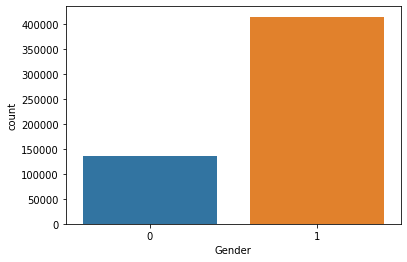

In [0]:
#Male VS Female
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

sns.countplot(x = 'Gender', data = pd_df)

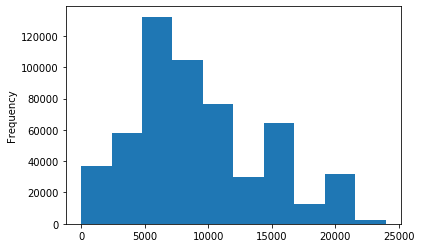

In [0]:
#Histogram of Purchase
pd_df['Purchase'].plot.hist()

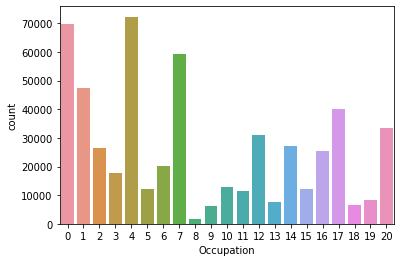

In [0]:
sns.countplot(x = 'Occupation', data = pd_df)

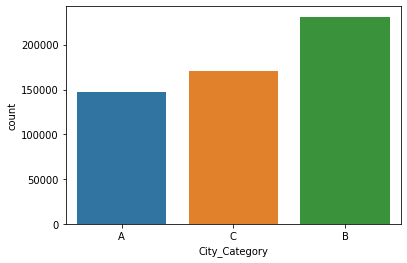

In [0]:
#City category
sns.countplot(x = 'City_Category', data = pd_df)

# **Data Cleaning**

In [0]:
#Checking null values
pd_df.isnull()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,False,False,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,False,False,False,False,False,False,False,False,False,True,True,False
550064,False,False,False,False,False,False,False,False,False,True,True,False
550065,False,False,False,False,False,False,False,False,False,True,True,False
550066,False,False,False,False,False,False,False,False,False,True,True,False


In [0]:
#Counting null values in each column
pd_df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

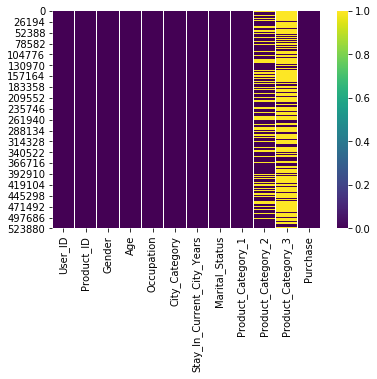

In [0]:
#Heat map
sns.heatmap(pd_df.isnull(), cmap = 'viridis')

In [0]:
#Replacing the null values in Product category2 and Product_Category3 with mode.
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imputer = imputer.fit(pd_df.iloc[:, 9:11].values)
pd_df.iloc[:,9:11] = imputer.transform(pd_df.iloc[:, 9:11].values)
pd_df.info() 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int32
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int32
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int32
Product_Category_1            550068 non-null int32
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int32
dtypes: float64(2), int32(5), object(5)
memory usage: 39.9+ MB


In [0]:
#Re-checing the missing values
pd_df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [0]:
#Dropping columns User_ID and Product_ID
pd_df.drop(['User_ID','Product_ID'], axis=1, inplace=True)
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int32
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int32
Product_Category_1            550068 non-null int32
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int32
dtypes: float64(2), int32(4), object(4)
memory usage: 33.6+ MB


In [0]:
pd_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,8.0,16.0,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,8.0,16.0,1422
3,F,0-17,10,A,2,0,12,14.0,16.0,1057
4,M,55+,16,C,4+,0,8,8.0,16.0,7969


In [0]:
#Removing + sign in age
pd_df['Age']=(pd_df['Age'].str.strip('+'))

In [0]:
#Removing + sign in Stay_In_Current_City_Years and converting it to float
pd_df['Stay_In_Current_City_Years']=(pd_df['Stay_In_Current_City_Years'].str.strip('+').astype('float'))

In [0]:
#Lets Explore the data once again
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int32
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null float64
Marital_Status                550068 non-null int32
Product_Category_1            550068 non-null int32
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int32
dtypes: float64(3), int32(4), object(3)
memory usage: 33.6+ MB


In [0]:
#Gender
#unique values in Gender parameter
gender = np.unique(pd_df['Gender'])
gender

array(['F', 'M'], dtype=object)

In [0]:
def map_gender(gender):
    if gender == 'M':
        return 1
    else:
        return 0
pd_df['Gender'] = pd_df['Gender'].apply(map_gender)

In [0]:
#Age
age = np.unique(pd_df['Age'])
age

array(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55'],
      dtype=object)

In [0]:
#we are having bins. Lets make these bins into numeric values
def map_age(age):
    if age == '0-17':
        return 0
    elif age == '18-25':
        return 1
    elif age == '26-35':
        return 2
    elif age == '36-45':
        return 3
    elif age == '46-50':
        return 4
    elif age == '51-55':
        return 5
    else:
        return 6
pd_df['Age'] = pd_df['Age'].apply(map_age)

In [0]:
#City category
city_category = np.unique(pd_df['City_Category'])
city_category

array(['A', 'B', 'C'], dtype=object)

In [0]:
def map_city_categories(city_category):
    if city_category == 'A':
        return 2
    elif city_category == 'B':
        return 1
    else:
        return 0
pd_df['City_Category'] = pd_df['City_Category'].apply(map_city_categories)

In [0]:
pd_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,2,2.0,0,3,8.0,16.0,8370
1,0,0,10,2,2.0,0,1,6.0,14.0,15200
2,0,0,10,2,2.0,0,12,8.0,16.0,1422
3,0,0,10,2,2.0,0,12,14.0,16.0,1057
4,1,6,16,0,4.0,0,8,8.0,16.0,7969


# **Multivariate Data Analysis**

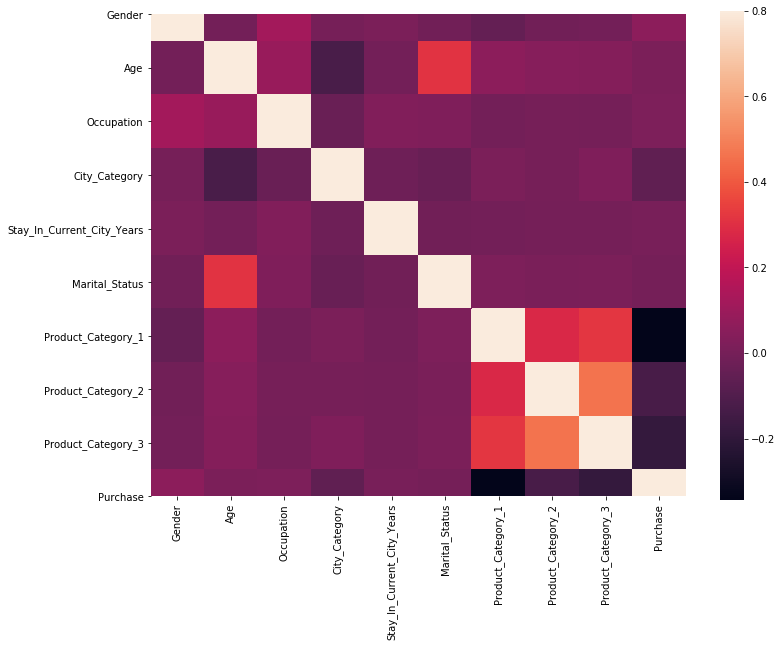

In [0]:
#Visualizing the statistical relationship between diffrent variables
corrmat = pd_df.corr()
fig,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [0]:
#1. Nothing is highly coorelated with purchase varibale
#2. Product_Category_1 has a negative correlation with Purchase.
#3 Maritial_Status and Age are strongly correlated. As Expected.
#4.Product_Category_3 has a strong correlation with Purchase. Maybe the products in this category were cheap. Let's chrun out some number related to this.

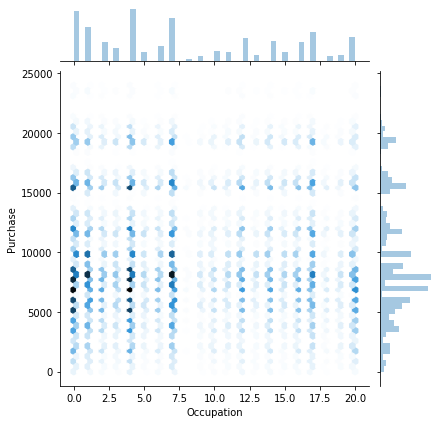

In [0]:
sns.jointplot(x='Occupation',y='Purchase',
              data=pd_df, kind='hex'
             )

In [0]:
#First insight would be that most of the purchase is done between 5000-10000.
#Next important insight, would be the occupations that lead to highest purchases. In this case, it would be occupation 4, listed in the dataset, closely followed that by 0 and

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


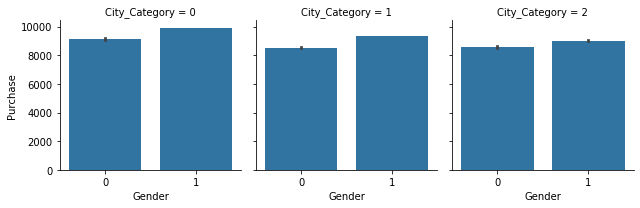

In [0]:
#Analysing pruchase behaviour across different city categories for each gender
g = sns.FacetGrid(pd_df,col="City_Category")
g.map(sns.barplot, "Gender", "Purchase");

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


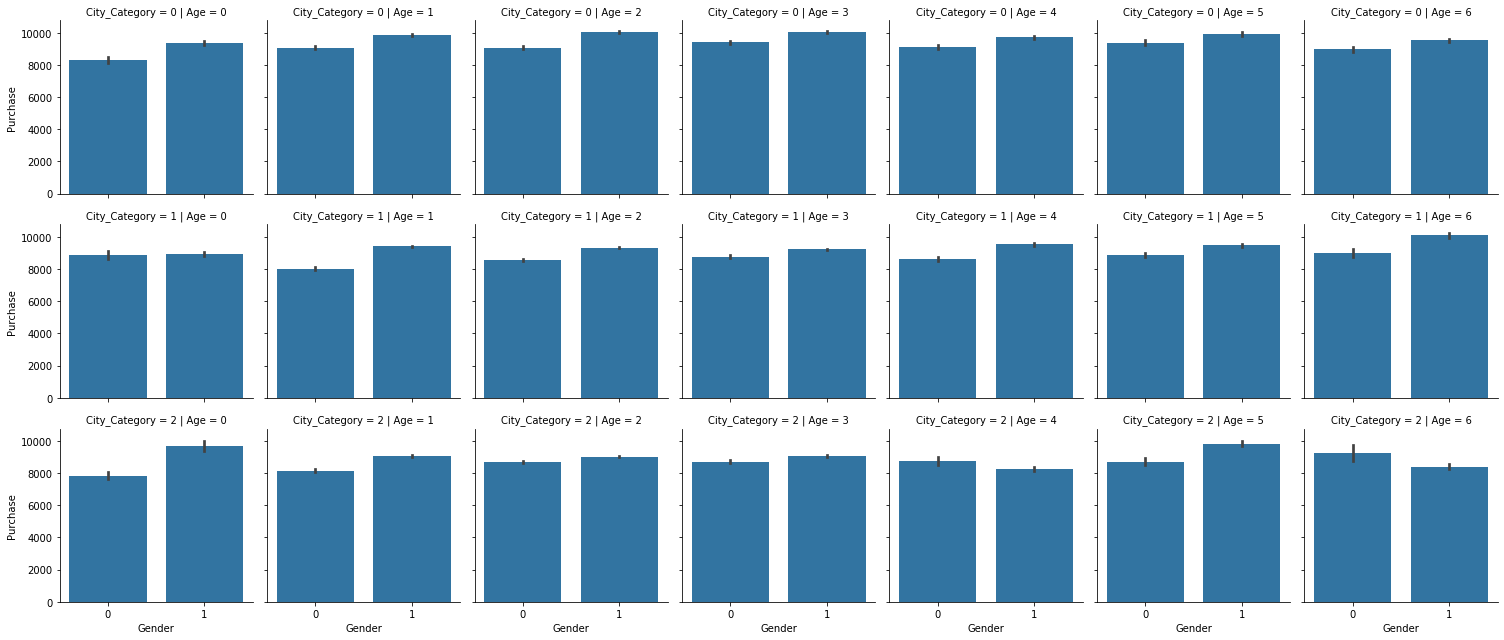

In [0]:
##Analysing pruchase behaviour across different city categories for each gender in diffrent age category
g = sns.FacetGrid(pd_df,col="Age",row="City_Category")
g.map(sns.barplot, "Gender", "Purchase");

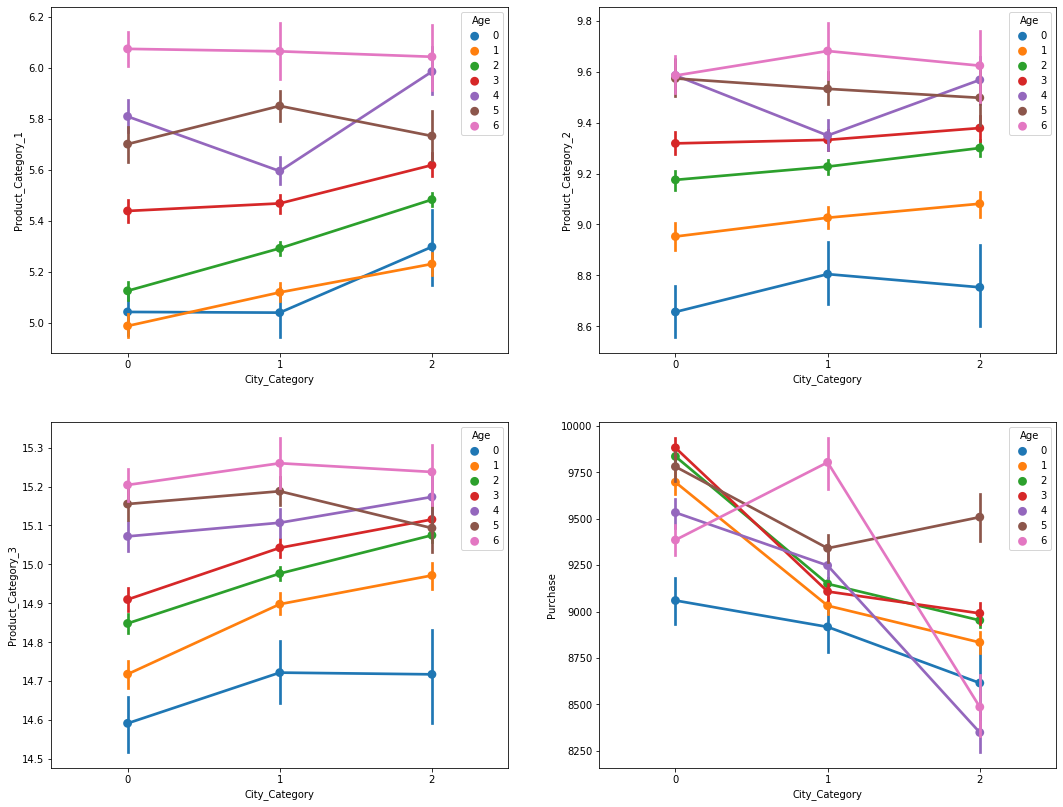

In [0]:
#Purchase behaviour accress each city category for diffreent age groups

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,14))
ax = sns.pointplot(y='Product_Category_1', x='City_Category',hue='Age',
                 data=pd_df,
                 ax=axes[0,0]
                )
ax = sns.pointplot(y='Product_Category_2', x='City_Category',hue='Age',
                 data=pd_df,
                 ax=axes[0,1]
                )
ax = sns.pointplot(y='Product_Category_3', x='City_Category', hue='Age',
                 data=pd_df,
                 ax=axes[1,0]
                )
ax = sns.pointplot(y='Purchase', x='City_Category', hue='Age',
                 data=pd_df,
                 ax=axes[1,1]
                )

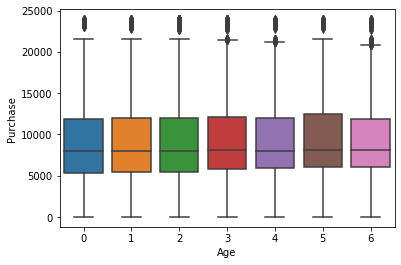

In [0]:
#boxplots to study the deviation in Age vs Purchase
sns.boxplot('Age','Purchase', data = pd_df)
plt.show()

In [0]:
spark_df = spark.createDataFrame(pd_df)

## **Modelling**

In [0]:
spark_df2 = spark_df.select("Gender", "Age", "Occupation", "City_Category","Stay_In_Current_City_Years", "Marital_Status", "Product_Category_1", "Product_Category_2", "Product_Category_3", spark_df.Purchase.alias('label'))

In [0]:
train, test = spark_df2.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 439871
Test Dataset Count: 110197


In [0]:
assembler = VectorAssembler().setInputCols(["Gender", "Age", "Occupation", "City_Category","Stay_In_Current_City_Years", "Marital_Status", "Product_Category_1", "Product_Category_2", "Product_Category_3" ,])\
.setOutputCol('features')
train01 = assembler.transform(train)

In [0]:
train02 = train01.select('features', 'label')
train02.show(truncate = False)

+---------------------------+-----+
|features                   |label|
+---------------------------+-----+
|(9,[6,7,8],[1.0,2.0,15.0]) |11379|
|(9,[6,7,8],[2.0,4.0,9.0])  |9542 |
|(9,[6,7,8],[2.0,4.0,9.0])  |9761 |
|(9,[6,7,8],[2.0,4.0,14.0]) |12708|
|(9,[6,7,8],[2.0,4.0,16.0]) |13138|
|(9,[6,7,8],[2.0,4.0,16.0]) |13217|
|(9,[6,7,8],[3.0,4.0,5.0])  |7948 |
|(9,[6,7,8],[3.0,4.0,5.0])  |13270|
|(9,[6,7,8],[3.0,4.0,16.0]) |10821|
|(9,[6,7,8],[4.0,5.0,16.0]) |2061 |
|(9,[6,7,8],[4.0,5.0,16.0]) |2119 |
|(9,[6,7,8],[4.0,5.0,16.0]) |2770 |
|(9,[6,7,8],[4.0,5.0,16.0]) |2807 |
|(9,[6,7,8],[4.0,8.0,16.0]) |2099 |
|(9,[6,7,8],[5.0,8.0,16.0]) |3740 |
|(9,[6,7,8],[5.0,8.0,16.0]) |6888 |
|(9,[6,7,8],[5.0,11.0,16.0])|5365 |
|(9,[6,7,8],[5.0,14.0,16.0])|5205 |
|(9,[6,7,8],[5.0,14.0,16.0])|8817 |
|(9,[6,7,8],[5.0,14.0,16.0])|8831 |
+---------------------------+-----+
only showing top 20 rows



In [0]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train02)
test01 = vec_assembler.transform(test)
test02 = test01.select('features', 'label')
test03 = model.transform(test02)
test03.show(truncate=False)

+---------------------------------+-----+------------------+
|features                         |label|prediction        |
+---------------------------------+-----+------------------+
|(9,[6,7,8],[4.0,5.0,16.0])       |2794 |9254.764860117912 |
|(9,[6,7,8],[8.0,8.0,16.0])       |7915 |7636.533777985297 |
|(9,[4,6,7,8],[1.0,1.0,2.0,5.0])  |15233|12190.110462702127|
|(9,[4,6,7,8],[1.0,1.0,15.0,16.0])|15759|10454.289513483309|
|(9,[4,6,7,8],[1.0,2.0,4.0,8.0])  |15965|11317.020754045072|
|(9,[4,6,7,8],[1.0,2.0,4.0,9.0])  |6438 |11161.728120021817|
|(9,[4,6,7,8],[1.0,2.0,4.0,9.0])  |16087|11161.728120021817|
|(9,[4,6,7,8],[1.0,3.0,4.0,16.0]) |10973|9671.714332958354 |
|(9,[4,6,7,8],[1.0,3.0,5.0,16.0]) |7974 |9669.591104115047 |
|(9,[4,6,7,8],[1.0,4.0,5.0,12.0]) |718  |9887.796291307397 |
|(9,[4,6,7,8],[1.0,4.0,5.0,16.0]) |1450 |9266.625755214372 |
|(9,[4,6,7,8],[1.0,4.0,5.0,16.0]) |2054 |9266.625755214372 |
|(9,[4,6,7,8],[1.0,5.0,8.0,16.0]) |3584 |8857.290719783778 |
|(9,[4,6,7,8],[1.0,5.0,8

In [0]:
evaluator = RegressionEvaluator()
print(evaluator.evaluate(test03,
{evaluator.metricName: "r2"})
)

0.12999129133779652


In [0]:
print(evaluator.evaluate(test03,
{evaluator.metricName: "mse"})
)
print(evaluator.evaluate(test03,
{evaluator.metricName: "rmse"})
)
print(evaluator.evaluate(test03,
{evaluator.metricName: "mae"})
)

21874026.952124175
4676.9677091171125
3576.8772132298354


In [0]:
from pyspark.ml.regression import LinearRegression
regression = LinearRegression(labelCol = 'Purchase')

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
RegressionEvaluator(labelCol='Purchase').evaluate(predictions)

4676.9677091171125

In [0]:
#Converting datatypes to numerical so that it can be used in spark


In [0]:
#Converting the Pandas dataframe to spark Data frame
#spark_df = spark.createDataFrame(pd_df)

In [0]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxIter=200)
model = gbt.fit(train02)
test01 = vec_assembler.transform(test)
test02 = test01.select('features', 'label')
test03 = model.transform(test02)
test03.show(truncate=False)

+---------------------------------+-----+------------------+
|features                         |label|prediction        |
+---------------------------------+-----+------------------+
|(9,[6,7,8],[4.0,5.0,16.0])       |2794 |2905.806755479731 |
|(9,[6,7,8],[8.0,8.0,16.0])       |7915 |8590.288033550183 |
|(9,[4,6,7,8],[1.0,1.0,2.0,5.0])  |15233|13508.645742561657|
|(9,[4,6,7,8],[1.0,1.0,15.0,16.0])|15759|14109.816904834077|
|(9,[4,6,7,8],[1.0,2.0,4.0,8.0])  |15965|13400.21786301889 |
|(9,[4,6,7,8],[1.0,2.0,4.0,9.0])  |6438 |11655.68027677495 |
|(9,[4,6,7,8],[1.0,2.0,4.0,9.0])  |16087|11655.68027677495 |
|(9,[4,6,7,8],[1.0,3.0,4.0,16.0]) |10973|9805.512814199854 |
|(9,[4,6,7,8],[1.0,3.0,5.0,16.0]) |7974 |11306.573552734517|
|(9,[4,6,7,8],[1.0,4.0,5.0,12.0]) |718  |3087.8107187062105|
|(9,[4,6,7,8],[1.0,4.0,5.0,16.0]) |1450 |2210.8626279040486|
|(9,[4,6,7,8],[1.0,4.0,5.0,16.0]) |2054 |2210.8626279040486|
|(9,[4,6,7,8],[1.0,5.0,8.0,16.0]) |3584 |6461.110198812819 |
|(9,[4,6,7,8],[1.0,5.0,8

In [0]:
evaluator = RegressionEvaluator()
print(evaluator.evaluate(test03,
{evaluator.metricName: "r2"})
)

0.6703819007410083


In [0]:
#RMSE
RegressionEvaluator(labelCol='label').evaluate(test03)

2943.014273977946